# Fetch Data from Reddit

In [1]:
import praw
import pandas as pd
import random
import time

# Set up Reddit API credential
user_agent = "Scraper 1.0 by /u/python_engineer"
reddit = praw.Reddit(
    client_id="UEXEYLHIZA6LmTq-dFlJPQ",
    client_secret="x5Gv8C2ZRR29Bn6C4LuFoolrrVNQOQ",
    user_agent=user_agent
)

def fetch_reddit_data(subreddit_name, headline_limit=100, comment_limit=50, sleep_time=2):
    submissions = reddit.subreddit(subreddit_name).hot(limit=1000)
    submission_list = [submission for submission in submissions]

    random.shuffle(submission_list)
    selected_submissions = submission_list[:headline_limit]

    data = []
    for idx, submission in enumerate(selected_submissions):
        print(f"Fetching submission {idx + 1}/{headline_limit}: {submission.title}")
        submission.comments.replace_more(limit=0)
        comments = submission.comments.list()
        comment_texts = [comment.body for comment in comments[:comment_limit]]
        data.append({
            'headline': submission.title,
            'comments': comment_texts
        })
        time.sleep(sleep_time)  
    
    return data

subreddit_name = 'pakistan'
data = fetch_reddit_data(subreddit_name)

rows = []
for entry in data:
    for comment in entry['comments']:
        rows.append({'headline': entry['headline'], 'comment': comment})

df = pd.DataFrame(rows)
df.to_csv('reddit_data.csv', header=True, encoding='utf-8', index=False)

print(f"Total rows fetched: {len(df)}")


Fetching submission 1/100: Rishta denial by GF's parents
Fetching submission 2/100: 22 Y/O making 8 lac per month
Fetching submission 3/100: Underage driving
Fetching submission 4/100: Iphone Dillema
Fetching submission 5/100: Arshad nadeem village's video after he won the gold medal 
Fetching submission 6/100: Has anybody here had this?
Fetching submission 7/100: Pakistan Economic Crisis: Why Pakistan's Economy Keeps Collapsing ?
Fetching submission 8/100: Health insurance for UK travel 
Fetching submission 9/100: Any Pakistanis here studying abroad on scholarships?
Fetching submission 10/100: Shein Group Ordering 
Fetching submission 11/100: Are there any TLP supporters in this subreddit?
Fetching submission 12/100: Bangladesh Revolution 
Fetching submission 13/100: Internet Issue 
Fetching submission 14/100: Is there any point to applying to US/WW jobs?
Fetching submission 15/100: This is how Pakistan is run [ Based on the announced Federal Budget 2024-25 ] 
Fetching submission 16/1

# Preprocess Text

In [2]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user @ references and '#' from hashtags
    text = re.sub(r'\@\w+|\#','', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

df['clean_headline'] = df['headline'].apply(preprocess_text)
df['clean_comment'] = df['comment'].apply(preprocess_text)

clean_df = df[['clean_headline', 'clean_comment']]

# Save the cleaned dataframe to a CSV file
clean_df.to_csv('clean_reddit_data.csv', header=True, encoding='utf-8', index=False)

print(f"Total cleaned rows saved: {len(clean_df)}")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Natha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Natha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Total cleaned rows saved: 1618


# Topic Modeling (LDA)

In [3]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from gensim import corpora, models

clean_df = pd.read_csv('clean_reddit_data.csv')

clean_df['clean_headline'] = clean_df['clean_headline'].astype(str).fillna('')
clean_df['clean_comment'] = clean_df['clean_comment'].astype(str).fillna('')

clean_texts = clean_df['clean_headline'].tolist() + clean_df['clean_comment'].tolist()

tokenized_texts = [word_tokenize(text) for text in clean_texts]

dictionary = corpora.Dictionary(tokenized_texts)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

lda_model = models.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=15, random_state=42)

for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx + 1}: {topic}")


Topic 1: 0.018*"get" + 0.012*"right" + 0.009*"man" + 0.008*"like" + 0.008*"marriage" + 0.007*"uk" + 0.007*"know" + 0.007*"dont" + 0.007*"streets" + 0.007*"cousin"
Topic 2: 0.050*"removed" + 0.015*"got" + 0.012*"cousin" + 0.011*"divorced" + 0.009*"distant" + 0.008*"parents" + 0.007*"like" + 0.007*"said" + 0.007*"mothers" + 0.007*"hell"
Topic 3: 0.040*"bangladesh" + 0.023*"help" + 0.020*"u" + 0.017*"isi" + 0.016*"needs" + 0.016*"anyone" + 0.015*"else" + 0.015*"pakistan" + 0.014*"family" + 0.014*"sheikh"
Topic 4: 0.033*"pakistan" + 0.011*"cousin" + 0.011*"video" + 0.010*"top" + 0.010*"bhi" + 0.010*"gold" + 0.010*"arshad" + 0.010*"marriage" + 0.009*"medal" + 0.009*"percentage"
Topic 5: 0.026*"army" + 0.024*"hai" + 0.020*"hain" + 0.020*"k" + 0.014*"pakistan" + 0.013*"nahi" + 0.013*"true" + 0.012*"freedom" + 0.012*"really" + 0.011*"recently"
Topic 6: 0.023*"card" + 0.018*"victim" + 0.018*"making" + 0.018*"month" + 0.017*"bangladeshi" + 0.017*"per" + 0.016*"8" + 0.016*"envious" + 0.015*"hai" 

# Sentiment Analysis

In [4]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

# Load the cleaned reddit data
clean_df = pd.read_csv('clean_reddit_data.csv')

# Convert all entries to strings and fill any NaN values with empty strings
clean_df['clean_headline'] = clean_df['clean_headline'].astype(str).fillna('')
clean_df['clean_comment'] = clean_df['clean_comment'].astype(str).fillna('')

sid = SentimentIntensityAnalyzer()

# Function to analyze sentiment with thresholds, try experimenting with thresholds (i find these thresholds to work well)
def analyze_sentiment(text, threshold=0.05):
    score = sid.polarity_scores(text)
    if score['compound'] >= threshold:
        return 'positive'
    elif score['compound'] <= -threshold:
        return 'negative'
    else:
        return 'neutral'

clean_df['headline_sentiment'] = clean_df['clean_headline'].apply(lambda x: analyze_sentiment(x, threshold=0.05))
clean_df['comment_sentiment'] = clean_df['clean_comment'].apply(lambda x: analyze_sentiment(x, threshold=0.05))

clean_df.to_csv('sentiment_reddit_data.csv', header=True, encoding='utf-8', index=False)

headline_sentiments = clean_df['headline_sentiment'].value_counts()
comment_sentiments = clean_df['comment_sentiment'].value_counts()

print("Headline Sentiment Analysis:")
print(f"Positive: {headline_sentiments.get('positive', 0)}")
print(f"Negative: {headline_sentiments.get('negative', 0)}")
print(f"Neutral: {headline_sentiments.get('neutral', 0)}")

print("\nComment Sentiment Analysis:")
print(f"Positive: {comment_sentiments.get('positive', 0)}")
print(f"Negative: {comment_sentiments.get('negative', 0)}")
print(f"Neutral: {comment_sentiments.get('neutral', 0)}")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Natha\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Headline Sentiment Analysis:
Positive: 414
Negative: 355
Neutral: 849

Comment Sentiment Analysis:
Positive: 690
Negative: 343
Neutral: 585


# Embedding

In [6]:
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from tqdm import tqdm

# Load the sentiment data
df = pd.read_csv('sentiment_reddit_data.csv')

# Load the model and tokenizer
model_name = "nlptown/bert-base-multilingual-uncased-sentiment" #model (i found this to work best)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Function to generate embeddings
def generate_embeddings(text, tokenizer, model):
    if isinstance(text, str):
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).cpu().numpy().flatten()
    else:
        return np.zeros(model.config.hidden_size)  # to handle errors

df['clean_headline'] = df['clean_headline'].astype(str)
df['clean_comment'] = df['clean_comment'].astype(str)

# Apply the function with a progress bar
tqdm.pandas(desc="Generating headline embeddings")
df['headline_embedding'] = df['clean_headline'].progress_apply(lambda x: generate_embeddings(x, tokenizer, model).tolist())

tqdm.pandas(desc="Generating comment embeddings")
df['comment_embedding'] = df['clean_comment'].progress_apply(lambda x: generate_embeddings(x, tokenizer, model).tolist())

df.to_csv('embedding_reddit_data.csv', header=True, encoding='utf-8', index=False)

print("Embeddings generated and saved to 'embedding_reddit_data.csv'.")


Generating comment embeddings: 100%|██████████| 1618/1618 [01:37<00:00, 16.57it/s]


Embeddings generated and saved to 'embedding_reddit_data.csv'.


# Train Random Forest and Evaluate

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import joblib

# Load the dataset with embeddings
df = pd.read_csv('embedding_reddit_data.csv')

# Ensure sentiment columns are strings
df['headline_sentiment'] = df['headline_sentiment'].astype(str).str.lower()
df['comment_sentiment'] = df['comment_sentiment'].astype(str).str.lower()

print("Unique values in 'headline_sentiment':", df['headline_sentiment'].unique())
print("Unique values in 'comment_sentiment':", df['comment_sentiment'].unique())

X_headline = np.array(df['headline_embedding'].apply(eval).tolist())
X_comment = np.array(df['comment_embedding'].apply(eval).tolist())
X = np.vstack((X_headline, X_comment))

y_headline = df['headline_sentiment'].tolist()
y_comment = df['comment_sentiment'].tolist()
y = y_headline + y_comment

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Saving the random forest model for future testing
joblib.dump(clf, 'random_forest_model.pkl')

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['negative', 'neutral', 'positive'])

print(f"Accuracy: {accuracy:.2f}")
print(report)

def get_sentiment_counts_and_samples(df, sentiment_col, sentiment_label, num_samples=5):
    df_filtered = df[df[sentiment_col] == sentiment_label]
    count = df_filtered.shape[0]
    samples = df_filtered.sample(min(num_samples, count))['clean_headline'].tolist()
    return count, samples

num_negative, negative_headlines = get_sentiment_counts_and_samples(df, 'headline_sentiment', 'negative')
num_neutral, neutral_headlines = get_sentiment_counts_and_samples(df, 'headline_sentiment', 'neutral')
num_positive, positive_headlines = get_sentiment_counts_and_samples(df, 'headline_sentiment', 'positive')

#print some example cases
print(f"\nNumber of negative headlines: {num_negative}\n")
print("Negative headlines:")
for headline in negative_headlines:
    print(f"- {headline}")

print(f"\nNumber of neutral headlines: {num_neutral}\n")
print("Neutral headlines:")
for headline in neutral_headlines:
    print(f"- {headline}")

print(f"\nNumber of positive headlines: {num_positive}\n")
print("Positive headlines:")
for headline in positive_headlines:
    print(f"- {headline}")


Unique values in 'headline_sentiment': ['neutral' 'positive' 'negative']
Unique values in 'comment_sentiment': ['positive' 'negative' 'neutral']
Accuracy: 0.88
              precision    recall  f1-score   support

    negative       0.83      0.82      0.82       131
     neutral       0.92      0.92      0.92       319
    positive       0.83      0.84      0.83       198

    accuracy                           0.88       648
   macro avg       0.86      0.86      0.86       648
weighted avg       0.87      0.88      0.87       648


Number of negative headlines: 355

Negative headlines:
- envious bangladeshi citizens
- unfair comparison pakistan bangladesh
- playing victim card
- anyone else traumatic experience beacon house schools
- playing victim card

Number of neutral headlines: 849

Neutral headlines:
- pakistan run based announced federal budget 202425
- arshad nadeem qualifies finals
- u think flee
- underage driving
- mbbs admission query

Number of positive headlines: 414


# Visualiztion

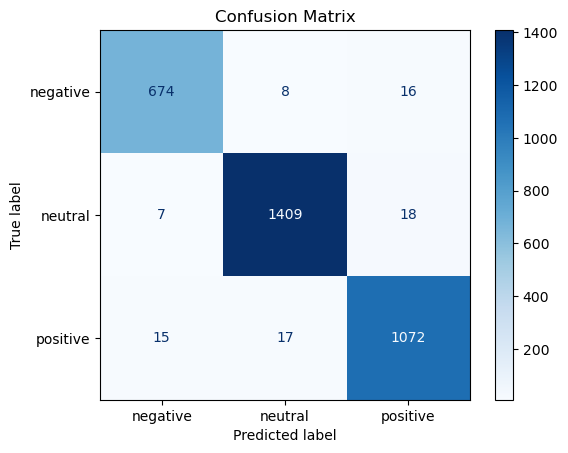

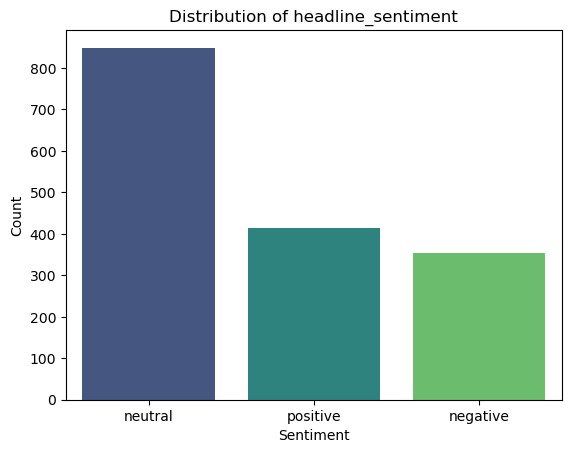

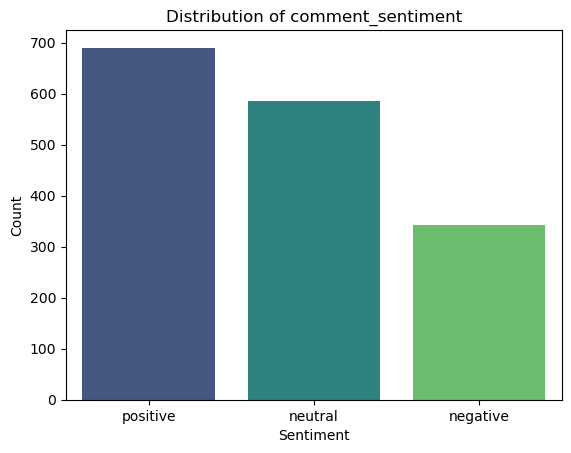

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

def plot_sentiment_distribution(df, column_name):
    sentiment_counts = df[column_name].value_counts()
    sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
    plt.title(f"Distribution of {column_name}")
    plt.xlabel("Sentiment")
    plt.ylabel("Count")
    plt.show()

df = pd.read_csv('embedding_reddit_data.csv')

y_true = df['headline_sentiment'].tolist() + df['comment_sentiment'].tolist()
y_pred = clf.predict(X)
labels = ['negative', 'neutral', 'positive']

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, labels)

# Plot sentiment distributions
plot_sentiment_distribution(df, 'headline_sentiment')
plot_sentiment_distribution(df, 'comment_sentiment')


# Testing the Random Forest

In [9]:
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
import joblib

# Load the pre-trained Random Forest model that we have just trained saved earlier
clf = joblib.load('random_forest_model.pkl')

# Loading BERT again because we will now make some headlines and make embeddings to test them
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Function to generate embeddings
def generate_embeddings(text, tokenizer, model):
    if isinstance(text, str):
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).cpu().numpy().flatten()
    else:
        return np.zeros(model.config.hidden_size)  # Return a zero vector if the input is not valid, handles errors basically

# sample random List of headlines to test
headlines = [
    "The government's outdated policies lead to a frustratingly poor experience for citizens.",
    "Pakistan's scenic beauty is breathtaking.",
    "The political situation in Pakistan is disgusting.",
    "The new economic reforms were worse than I expected them to be.",
    "Why do politicians scam us by making false promises?",
    "This government's policies are really bad at engaging the public, just like previous administrations.",
    "The political system is riddled with corruption and fails to deliver.",
    "The economic growth is repetitive and lacks any real substance.",
    "The infrastructure is outdated and looks terrible compared to neighboring countries.",
    "The government's response to crises is poorly planned and fails to engage the public.",
    "The public services are unresponsive and frustrating to use.",
    "The economy is filled with inflationary pressures that ruin the experience for the middle class.",
    "The healthcare system is terribly designed and offers no real benefits.",
    "The educational reforms are bland and lack creativity.",
    "The government's performance is sluggish even in high-priority areas.",
    "The media censorship is awful and detracts from the overall experience of democracy.",
    "Why are politicians making terrible decisions these days?",
    "Pakistan's natural resources are really incredible for boosting the economy."
]


for headline in headlines:
    embedding = generate_embeddings(headline, tokenizer, model)
    
    predicted_class = clf.predict(embedding.reshape(1, -1))[0]
    
    print(f"Headline: '{headline}'")
    print(f"The predicted sentiment is: {predicted_class.capitalize()}\n")


Headline: 'The government's outdated policies lead to a frustratingly poor experience for citizens.'
The predicted sentiment is: Negative

Headline: 'Pakistan's scenic beauty is breathtaking.'
The predicted sentiment is: Positive

Headline: 'The political situation in Pakistan is disgusting.'
The predicted sentiment is: Negative

Headline: 'The new economic reforms were worse than I expected them to be.'
The predicted sentiment is: Positive

Headline: 'Why do politicians scam us by making false promises?'
The predicted sentiment is: Negative

Headline: 'This government's policies are really bad at engaging the public, just like previous administrations.'
The predicted sentiment is: Negative

Headline: 'The political system is riddled with corruption and fails to deliver.'
The predicted sentiment is: Negative

Headline: 'The economic growth is repetitive and lacks any real substance.'
The predicted sentiment is: Neutral

Headline: 'The infrastructure is outdated and looks terrible compa

# Top 25 Most Common Words For Both Positive And Negative Sentiments in Dataset Using NLTK

In [10]:
import pandas as pd
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

# Load the sentiment data
df = pd.read_csv('sentiment_reddit_data.csv')

df['combined_text'] = df['clean_headline'].astype(str).fillna('') + ' ' + df['clean_comment'].astype(str).fillna('')

# Function to tokenize text and remove stop words
def tokenize_and_filter(text):
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return filtered_tokens

# Apply the function to the combined_text column
df['tokens'] = df['combined_text'].apply(tokenize_and_filter)

# Initialize VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Function to determine if a word is positive or negative using VADER
def word_sentiment(word):
    score = sid.polarity_scores(word)
    if score['compound'] >= 0.05:
        return 'positive'
    elif score['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

positive_tokens = []
negative_tokens = []

for tokens in df['tokens']:
    for word in tokens:
        sentiment = word_sentiment(word)
        if sentiment == 'positive':
            positive_tokens.append(word)
        elif sentiment == 'negative':
            negative_tokens.append(word)

# Count frequencies
positive_word_counts = Counter(positive_tokens)
negative_word_counts = Counter(negative_tokens)

# Get the top 25 most common words for each sentiment
top_positive_words = positive_word_counts.most_common(25)
top_negative_words = negative_word_counts.most_common(25)

print("Top 25 most common words in positive sentiment:")
for word, count in top_positive_words:
    print(f"{word}: {count}")

print("\nTop 25 most common words in negative sentiment:")
for word, count in top_negative_words:
    print(f"{word}: {count}")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Natha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Natha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Natha\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Top 25 most common words in positive sentiment:
like: 172
help: 113
good: 108
please: 101
thank: 87
love: 84
true: 66
want: 63
well: 63
top: 59
feeling: 58
medal: 57
freedom: 57
hand: 54
playing: 52
best: 51
friend: 51
better: 50
support: 42
friends: 31
hope: 31
lol: 29
yes: 29
safe: 27
sure: 26

Top 25 most common words in negative sentiment:
low: 70
spam: 62
victim: 60
kill: 57
kia: 54
insane: 53
envious: 53
doubt: 52
crisis: 41
collapsing: 40
traumatic: 38
fighters: 37
hard: 29
wrong: 28
bad: 27
problem: 25
hate: 24
shit: 24
foolish: 24
hell: 22
sorry: 20
jailed: 20
unfair: 20
alone: 17
war: 16


# Visualiztion Of Top 25 Most Common Words For Both Positive And Negative Sentiments in Dataset

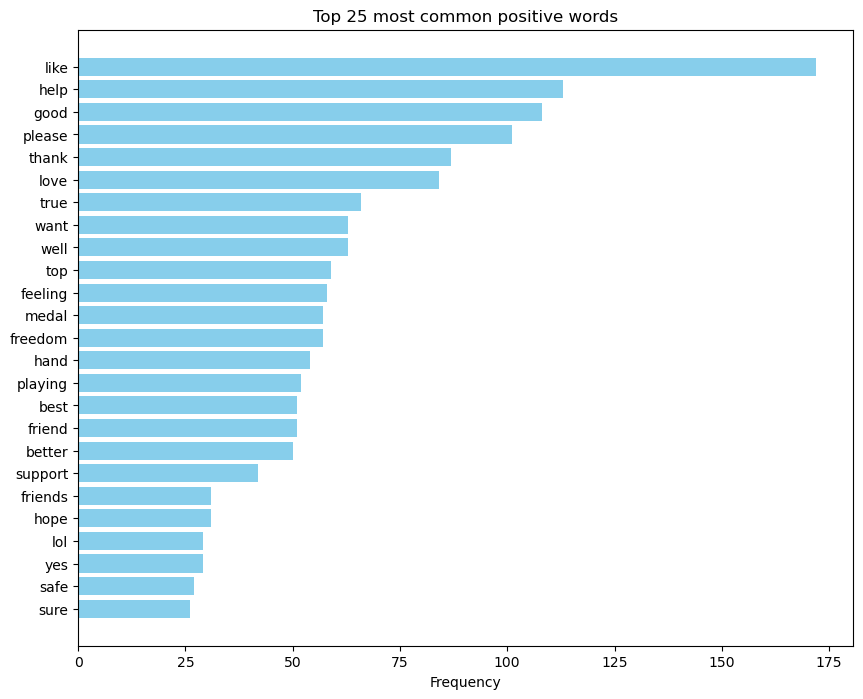

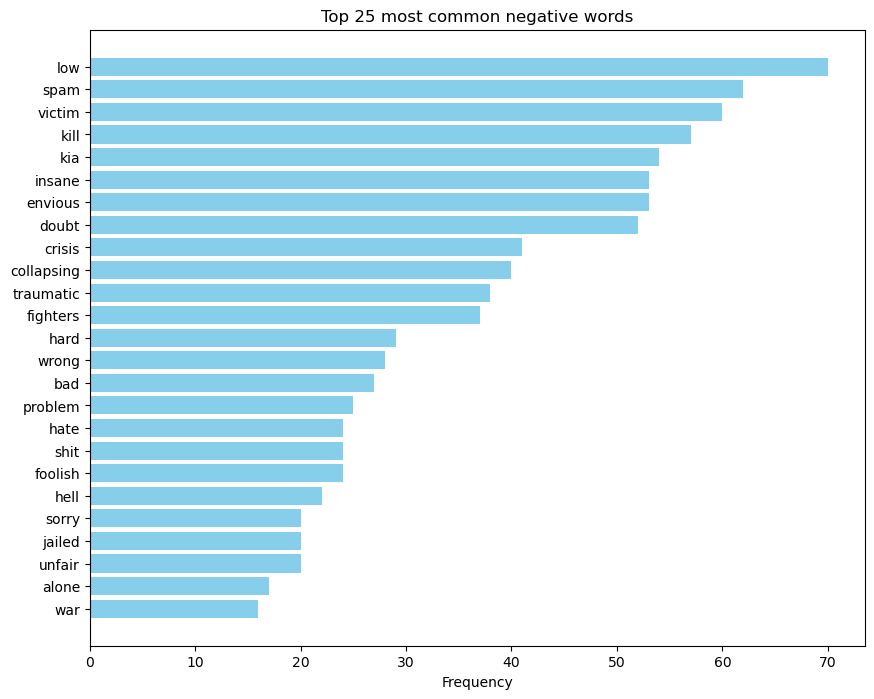

In [11]:

import matplotlib.pyplot as plt

def plot_word_counts(word_counts, title):
    words, counts = zip(*word_counts)
    plt.figure(figsize=(10, 8))
    plt.barh(words, counts, color='skyblue')
    plt.xlabel('Frequency')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

# Plot for positive words
plot_word_counts(top_positive_words, 'Top 25 most common positive words')

# Plot for negative words
plot_word_counts(top_negative_words, 'Top 25 most common negative words')


# Extracting sentiment and most imapactful words along with imapact score using BERT

In [12]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm

# Load cleaned Reddit data
clean_df = pd.read_csv('clean_reddit_data.csv')

# Ensure all comments are strings
clean_df['clean_comment'] = clean_df['clean_comment'].astype(str)

model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def get_sentiment_scores(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    outputs = model(**inputs)
    scores = torch.nn.functional.softmax(outputs.logits, dim=-1)
    return scores

def analyze_sentiments_and_impact(df):
    results = []
    
    for comment in tqdm(df['clean_comment'], desc="Analyzing sentiments and impact"):
        words = comment.split()
        if not words:
            continue

        full_scores = get_sentiment_scores(comment)
        full_sentiment = torch.argmax(full_scores).item()
        
        max_impact = 0
        impactful_word = ""
        impactful_word_score = 0
        
        for word in words:
            modified_comment = " ".join([w for w in words if w != word])
            modified_scores = get_sentiment_scores(modified_comment)
            modified_sentiment = torch.argmax(modified_scores).item()

            impact_score = torch.abs(full_scores - modified_scores).max().item()
            
            if impact_score > max_impact:
                max_impact = impact_score
                impactful_word = word
                impactful_word_score = impact_score
        
        sentiment_label = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"][full_sentiment]
        results.append({
            "comment": comment,
            "sentiment": sentiment_label,
            "impactful_word": impactful_word,
            "impactful_word_score": impactful_word_score
        })
    
    return results

# Analyze sentiments and identify impactful words
results = analyze_sentiments_and_impact(clean_df)

# Print results
for result in results:
    print(f"Comment: {result['comment']}")
    print(f"Sentiment: {result['sentiment']}")
    print(f"Most Impactful Word: {result['impactful_word']}")
    print(f"Impact Score: {result['impactful_word_score']}\n")


Analyzing sentiments and impact: 100%|██████████| 1618/1618 [10:31<00:00,  2.56it/s]

Comment: thank serving reminder get relationships
Sentiment: Very Positive
Most Impactful Word: thank
Impact Score: 0.18891587853431702

Comment: focus studies block u r financially stable try
Sentiment: Positive
Most Impactful Word: stable
Impact Score: 0.20063024759292603

Comment: first get rid rs youre investing mental health point take break ask take break time till things get better shes naseeb shell find way youre acca headache acca clear kro aram se dont think theyll ever agree financial status considering stable bahany kar rahay hain never would agree ab ego pr baat gae hai unki also dont send parents got humiliated enough times youve done enough youre still rs youre wrong naseeb mein hui tou mil jae gi youre still tou point want get hurt
Sentiment: Very Negative
Most Impactful Word: break
Impact Score: 0.047197163105010986

Comment: aur gf rakha karo shabash sane father rightfully giving daughter man kept gf 3 years men know well kind men keep gf go repent maybe find someone 

# Correlation Heatmap Of Top 10 Most impactful words of both positive and negative sentiment with impact score 

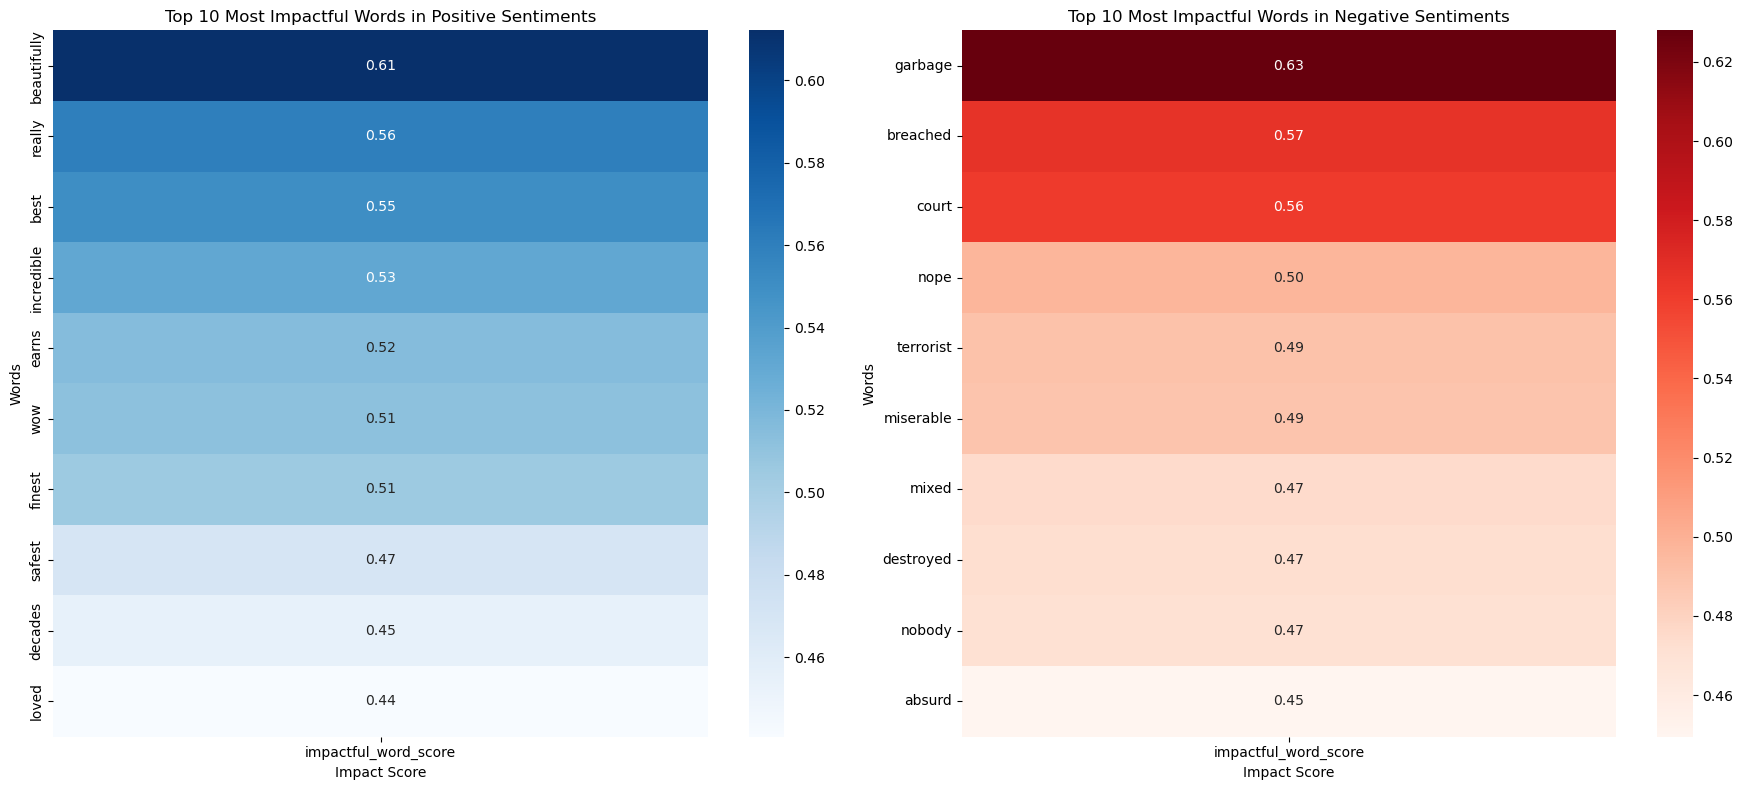

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

results_df = pd.DataFrame(results)

top_positive_words = results_df[results_df['sentiment'].isin(['Positive', 'Very Positive'])] \
    .groupby('impactful_word')['impactful_word_score'].mean() \
    .nlargest(10).reset_index()

top_negative_words = results_df[results_df['sentiment'].isin(['Negative', 'Very Negative'])] \
    .groupby('impactful_word')['impactful_word_score'].mean() \
    .nlargest(10).reset_index()

positive_heatmap_data = top_positive_words[['impactful_word', 'impactful_word_score']]
negative_heatmap_data = top_negative_words[['impactful_word', 'impactful_word_score']]

positive_heatmap_data.set_index('impactful_word', inplace=True)
negative_heatmap_data.set_index('impactful_word', inplace=True)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

sns.heatmap(positive_heatmap_data, annot=True, cmap='Blues', fmt='.2f', ax=axes[0])
axes[0].set_title('Top 10 Most Impactful Words in Positive Sentiments')
axes[0].set_xlabel('Impact Score')
axes[0].set_ylabel('Words')

sns.heatmap(negative_heatmap_data, annot=True, cmap='Reds', fmt='.2f', ax=axes[1])
axes[1].set_title('Top 10 Most Impactful Words in Negative Sentiments')
axes[1].set_xlabel('Impact Score')
axes[1].set_ylabel('Words')

plt.tight_layout()
plt.show()


# Top 25 Most Common Words For Both Positive And Negative Sentiments in Dataset Using BERT

In [15]:
import pandas as pd
from collections import Counter

results_df = pd.DataFrame(results)

positive_results = results_df[results_df['sentiment'].str.contains('Positive')]
negative_results = results_df[results_df['sentiment'].str.contains('Negative')]

positive_words = positive_results['impactful_word']
negative_words = negative_results['impactful_word']

positive_word_counts = Counter(positive_words)
negative_word_counts = Counter(negative_words)

positive_word_counts_df = pd.DataFrame(positive_word_counts.items(), columns=['Word', 'Frequency'])
negative_word_counts_df = pd.DataFrame(negative_word_counts.items(), columns=['Word', 'Frequency'])

top_25_positive_words_df = positive_word_counts_df.sort_values(by='Frequency', ascending=False).head(25)
top_25_negative_words_df = negative_word_counts_df.sort_values(by='Frequency', ascending=False).head(25)

print("Top 25 Most Common Impactful Words in Positive Sentiments:")
print(top_25_positive_words_df)

print("\nTop 25 Most Common Impactful Words in Negative Sentiments:")
print(top_25_negative_words_df)


Top 25 Most Common Impactful Words in Positive Sentiments:
          Word  Frequency
5         good         12
46        true          8
13        well          6
35       great          6
47      thanks          5
199   greatest          5
133       know          4
8         love          4
187      sweet          4
53        like          3
203     lumber          3
19       happy          3
175    exactly          3
148      years          3
11       makes          3
156    welcome          3
120       hell          3
165       help          2
1       stable          2
155       yeah          2
55         yes          2
62     support          2
66   excellent          2
68       every          2
204   accurate          2

Top 25 Most Common Impactful Words in Negative Sentiments:
         Word  Frequency
3     removed        163
9    accounts         61
89        one         19
11    deleted         16
290       hai         11
43        nan         11
178       bad         11
50   

# VISUALIZATION

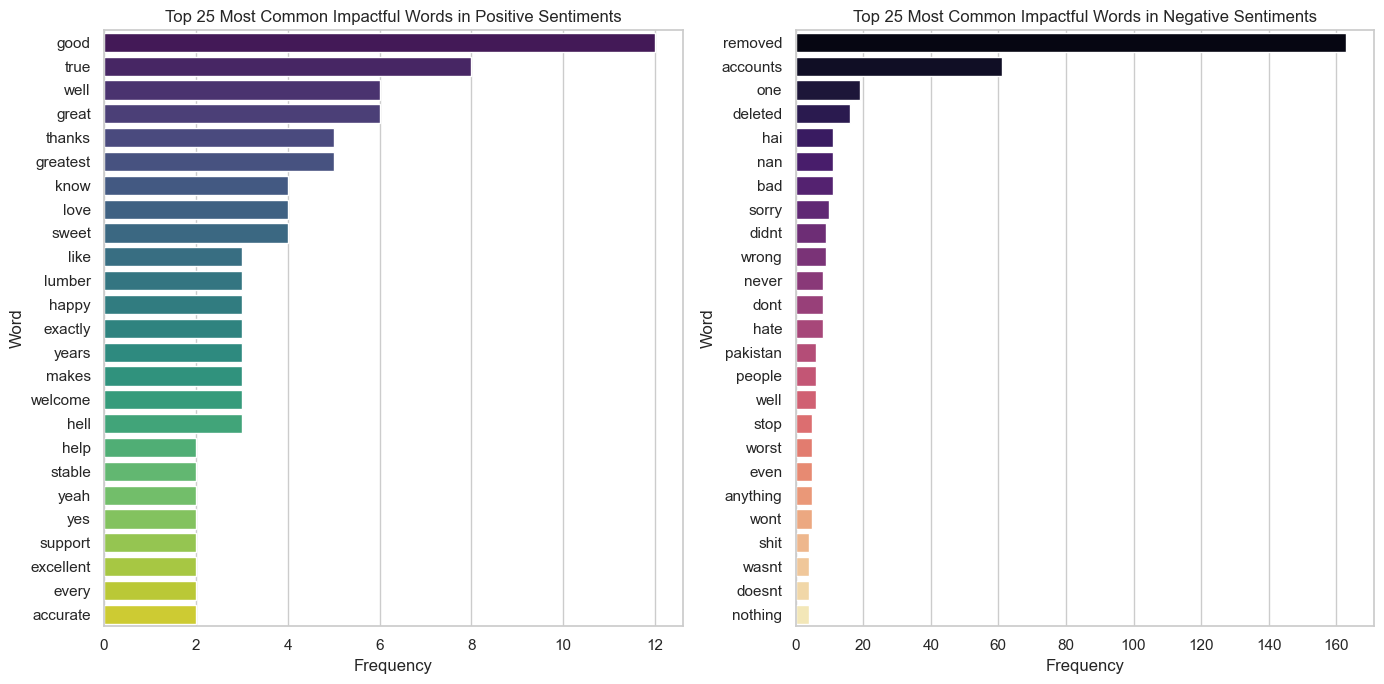

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 7))
sns.set(style="whitegrid")

plt.subplot(1, 2, 1)
sns.barplot(data=top_25_positive_words_df, x='Frequency', y='Word', palette='viridis')
plt.title('Top 25 Most Common Impactful Words in Positive Sentiments')
plt.xlabel('Frequency')
plt.ylabel('Word')

plt.subplot(1, 2, 2)
sns.barplot(data=top_25_negative_words_df, x='Frequency', y='Word', palette='magma')
plt.title('Top 25 Most Common Impactful Words in Negative Sentiments')
plt.xlabel('Frequency')
plt.ylabel('Word')

plt.tight_layout()

plt.show()


# Word Cloud Of Top 25 Common Positive And Negative

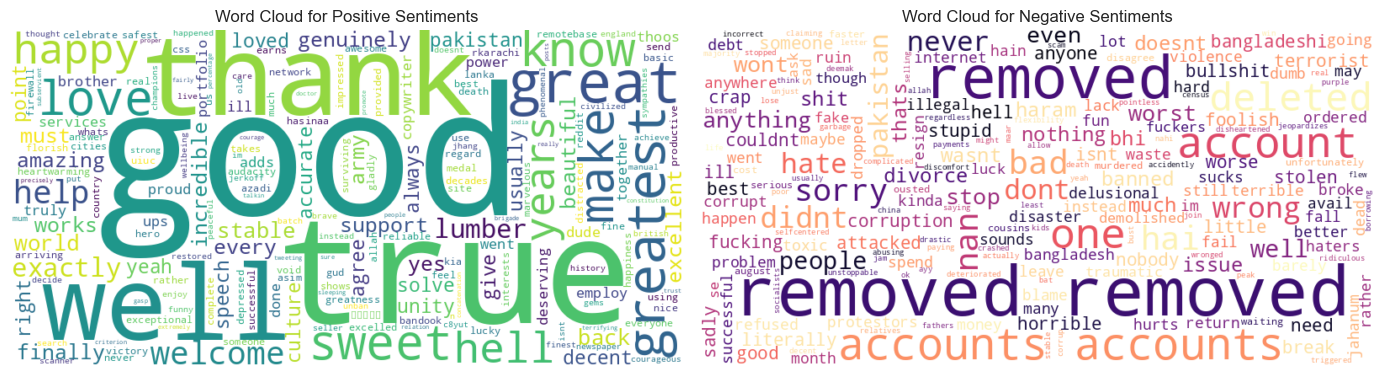

In [17]:
from wordcloud import WordCloud

# Combine the impactful words for positive and negative sentiments into single strings
positive_text = ' '.join(positive_results['impactful_word'])
negative_text = ' '.join(negative_results['impactful_word'])

# Create word clouds
positive_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(positive_text)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='magma').generate(negative_text)

# Plot the word clouds
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Sentiments')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Sentiments')

plt.tight_layout()
plt.show()


# NMF Topic Modeling On Whole Dataset

In [18]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import numpy as np

clean_df = pd.read_csv('clean_reddit_data.csv')

# Ensure all comments are strings
clean_df['clean_comment'] = clean_df['clean_comment'].astype(str)

text_data = clean_df['clean_comment'].tolist()

vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)
X = vectorizer.fit_transform(text_data)

num_topics = 10  # Number of topics you want to extract try experimenting with different
nmf_model = NMF(n_components=num_topics, random_state=42)
nmf_topics = nmf_model.fit_transform(X)

# Extracting Top Words for each Topic
feature_names = np.array(vectorizer.get_feature_names_out())
topics = []

for topic_idx, topic in enumerate(nmf_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
    topics.append(f"Topic {topic_idx + 1}: {' '.join(top_words)}")

for topic in topics:
    print(topic)


Topic 1: removed reddit dumb china religion celebrations weeks order power hasina
Topic 2: accounts moderators submissions approve karma review placed spam prevent low
Topic 3: deleted lmao marriages likely cousin million son hell daughter way
Topic 4: people dont like know think family thats good life country
Topic 5: nan lol actually yeah moment tell yea isi better pakistanis
Topic 6: moderators comment pending approval added automatically thank bot performed subredditmessagecomposetorpakistan
Topic 7: hai ka bhi bhai ko ki ho hain nahi se
Topic 8: pakistan lol bangladesh time india home sweet isi help pakistani
Topic 9: army power people chief military neutral khan bangladesh napak students
Topic 10: true thanks statement unfortunately post sadly great info freedom understand


# NMF Topic Modeling on Positive Sentiment Comments

In [19]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import numpy as np

# Load the sentiment analysis data
sentiment_df = pd.read_csv('sentiment_reddit_data.csv')

# Filter positive sentiment comments
positive_comments = sentiment_df[sentiment_df['comment_sentiment'] == 'positive']['clean_comment'].tolist()

if not positive_comments:
    print("No positive sentiment comments found.")
else:
    vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)
    X = vectorizer.fit_transform(positive_comments)

    # Apply NMF Topic Modeling
    num_topics = 10  # Number of topics you want to extract 
    nmf_model = NMF(n_components=num_topics, random_state=42)
    nmf_topics = nmf_model.fit_transform(X)

    # Extracting Top Words for each Topic
    feature_names = np.array(vectorizer.get_feature_names_out())
    topics = []

    for topic_idx, topic in enumerate(nmf_model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
        topics.append(f"Topic {topic_idx + 1}: {' '.join(top_words)}")

    for topic in topics:
        print(topic)


Topic 1: accounts moderators approve placed karma review submissions spam prevent soon
Topic 2: people good dont family better want know need life way
Topic 3: moderators comment added approval pending automatically performed subredditmessagecomposetorpakistan bot concerns
Topic 4: thanks great post creative info model information tho anyways sharing
Topic 5: true statement unfortunately politicians understand people post sacrifice requires freedom
Topic 6: lol isi pakistanis actually tell moment yea police better think
Topic 7: shit honestly freedom greatest die yaar thing life speech ofc
Topic 8: pakistan sweet home army help country time people support big
Topic 9: like think whats pakistani isi hai feel sounds im built
Topic 10: yes religion best tlp ah agency british surely expect went


# NMF Topic Modeling on Negative Sentiment Comments

In [20]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import numpy as np

sentiment_df = pd.read_csv('sentiment_reddit_data.csv')

# Filter negative sentiment comments
negative_comments = sentiment_df[sentiment_df['comment_sentiment'] == 'negative']['clean_comment'].tolist()

if not negative_comments:
    print("No negative sentiment comments found.")
else:
    vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)
    X = vectorizer.fit_transform(negative_comments)

    # Apply NMF Topic Modeling
    num_topics = 10  # Number of topics you want to extract
    nmf_model = NMF(n_components=num_topics, random_state=42)
    nmf_topics = nmf_model.fit_transform(X)

    # Extracting Top Words for each Topic
    feature_names = np.array(vectorizer.get_feature_names_out())
    topics = []

    for topic_idx, topic in enumerate(nmf_model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
        topics.append(f"Topic {topic_idx + 1}: {' '.join(top_words)}")

    for topic in topics:
        print(topic)


Topic 1: family like really time hard thats know trying didnt world
Topic 2: hell definitely eventually likely marriages fine cousin talking bit guy
Topic 3: pakistan india beating state partition bangladesh government point follow isnt
Topic 4: hai bhi ki ko mein ka se nai hain nahi
Topic 5: hate im bc day right isi indian days leaving going
Topic 6: army pakistani people military power fought students 1971 ershads confrontation
Topic 7: problem nation come things dead support hai life willing husband
Topic 8: sorry whats idk dumb student medical man question jaldi group
Topic 9: country people fail days home criticism came govt democratic running
Topic 10: dont want thing increase haters value worry need people school


# LSA Topic Modeling on Entire Dataset

In [21]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import numpy as np

clean_df = pd.read_csv('clean_reddit_data.csv')

# Fill NaN values with empty strings
clean_df['clean_headline'] = clean_df['clean_headline'].fillna('')
clean_df['clean_comment'] = clean_df['clean_comment'].fillna('')

combined_texts = clean_df['clean_headline'].tolist() + clean_df['clean_comment'].tolist()

# Ensure all entries are strings to avoid errors
combined_texts = [str(text) for text in combined_texts]

vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)
X = vectorizer.fit_transform(combined_texts)

# Apply LSA (Latent Semantic Analysis)
num_topics = 10  # Number of topics you want to extract
lsa_model = TruncatedSVD(n_components=num_topics, random_state=42)
lsa_topics = lsa_model.fit_transform(X)

# Extracting Top Words for each Topic
feature_names = np.array(vectorizer.get_feature_names_out())
topics = []

for topic_idx, topic in enumerate(lsa_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
    topics.append(f"Topic {topic_idx + 1}: {' '.join(top_words)}")

for topic in topics:
    print(topic)


Topic 1: removed reddit dumb china religion celebrations weeks order power automatically
Topic 2: cousin marriage pakistan worlwide percentage rates world distant divorced got
Topic 3: moderators accounts questions automatically subredditmessagecomposetorpakistan performed bot contact queue concerns
Topic 4: bangladesh help needs pakistan family disgraceful hasinas exit doubt hand
Topic 5: nadeem arshad villages medal gold video qualifies finals pakistan moderators
Topic 6: pakistani nikaltay kyun nahin realise living questions nadeem arshad villages
Topic 7: pakistan leaving feeling hit recently really federal 202425 budget announced
Topic 8: family expense monthly 45 grocery question days disgraceful exit doubt
Topic 9: hai azaadi pakistaniu haasil rok cheez kia sey rahi karne
Topic 10: era desi families love playing victim card marriage needs help


# LSA Topic Modeling on Positive Sentiment Comments

In [22]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import numpy as np

sentiment_df = pd.read_csv('sentiment_reddit_data.csv')

# Ensure no NaN values in text columns to handle errors 
sentiment_df['clean_headline'] = sentiment_df['clean_headline'].fillna('')
sentiment_df['clean_comment'] = sentiment_df['clean_comment'].fillna('')

# Filter positive sentiment comments
positive_comments = sentiment_df[sentiment_df['comment_sentiment'] == 'positive']['clean_comment'].tolist()

positive_texts = sentiment_df[sentiment_df['headline_sentiment'] == 'positive']['clean_headline'].tolist() + positive_comments

combined_texts = positive_comments

# Text Vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)
X = vectorizer.fit_transform(combined_texts)


num_topics = 10  # Number of topics you want to extract
lsa_model = TruncatedSVD(n_components=num_topics, random_state=42)
lsa_topics = lsa_model.fit_transform(X)

# Extracting Top Words for each Topic
feature_names = np.array(vectorizer.get_feature_names_out())
topics = []

for topic_idx, topic in enumerate(lsa_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
    topics.append(f"Topic {topic_idx + 1}: {' '.join(top_words)}")

for topic in topics:
    print(topic)


Topic 1: moderators accounts automatically subredditmessagecomposetorpakistan performed moderation bot concerns queue hello
Topic 2: like people pakistan dont good know think better time family
Topic 3: comment added approval pending moderators automatically thank bot concerns subredditmessagecomposetorpakistan
Topic 4: thanks great true post creative info model information lol tho
Topic 5: true statement unfortunately freedom politicians people understand honestly die greatest
Topic 6: lol pakistan true isi actually people pakistanis sweet police know
Topic 7: lol shit freedom honestly die greatest yaar thing life pakistan
Topic 8: pakistan home sweet like army help thanks support big time
Topic 9: like family lol think yes guys whats thanks true marriage
Topic 10: yes know best dont tlp people religion thats help want


# LSA Topic Modeling on Negative Sentiment Comments

In [23]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import numpy as np

sentiment_df = pd.read_csv('sentiment_reddit_data.csv')

# Ensure no NaN values in text columns to handle errors
sentiment_df['clean_headline'] = sentiment_df['clean_headline'].fillna('')
sentiment_df['clean_comment'] = sentiment_df['clean_comment'].fillna('')

# Filter negative sentiment comments
negative_comments = sentiment_df[sentiment_df['comment_sentiment'] == 'negative']['clean_comment'].tolist()

negative_texts = sentiment_df[sentiment_df['headline_sentiment'] == 'negative']['clean_headline'].tolist() + negative_comments

combined_texts = negative_comments

vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)
X = vectorizer.fit_transform(combined_texts)

num_topics = 10  # Number of topics you want to extract
lsa_model = TruncatedSVD(n_components=num_topics, random_state=42)
lsa_topics = lsa_model.fit_transform(X)

# Extracting Top Words for each Topic
feature_names = np.array(vectorizer.get_feature_names_out())
topics = []

for topic_idx, topic in enumerate(lsa_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
    topics.append(f"Topic {topic_idx + 1}: {' '.join(top_words)}")

for topic in topics:
    print(topic)


Topic 1: pakistan people dont army like thats think hate bangladesh time
Topic 2: hell sorry definitely dont family eventually marriages hate cousin likely
Topic 3: hell pakistan india eventually army definitely beating military sorry destroyed
Topic 4: hai bhi problem ki mein ko ka se nai nahi
Topic 5: hate im army people country days bc day indian believe
Topic 6: army dont people pakistani military students right bangladesh power fought
Topic 7: problem right bangladesh nation guy come going dead students isi
Topic 8: country nation hard shit dead home army came think people
Topic 9: problem bad people women cousin life things way marriages thats
Topic 10: sorry war hard think whats world army really family thats


# NER (NAMED ENTITY RECOGNITION USING BERT) AND TOXICITY DETECTION USNIG BERT

In [24]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForTokenClassification, pipeline
import nltk
from nltk.tokenize import sent_tokenize
import tqdm
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from collections import Counter
import ast

nltk.download('punkt')

tokenizer_ner = BertTokenizer.from_pretrained('dbmdz/bert-large-cased-finetuned-conll03-english')
model_ner = BertForTokenClassification.from_pretrained('dbmdz/bert-large-cased-finetuned-conll03-english')

sentiment_analyzer = pipeline('sentiment-analysis', model='nlptown/bert-base-multilingual-uncased-sentiment', tokenizer='nlptown/bert-base-multilingual-uncased-sentiment')

toxicity_analyzer = pipeline('text-classification', model='JungleLee/bert-toxic-comment-classification', tokenizer='JungleLee/bert-toxic-comment-classification')

# Define a maximum sequence length for BERT
MAX_SEQ_LENGTH = 512

# Function to perform NER with text chunking
def perform_ner(text):
    tokens = tokenizer_ner.tokenize(text)
    chunks = [tokens[i:i + MAX_SEQ_LENGTH - 2] for i in range(0, len(tokens), MAX_SEQ_LENGTH - 2)]
    results = []
    
    for chunk in chunks:
        # Add special tokens [CLS] and [SEP]
        input_ids = tokenizer_ner.convert_tokens_to_ids(['[CLS]'] + chunk + ['[SEP]'])
        attention_mask = [1] * len(input_ids)
        
        # Pad sequences to MAX_SEQ_LENGTH
        if len(input_ids) < MAX_SEQ_LENGTH:
            padding_length = MAX_SEQ_LENGTH - len(input_ids)
            input_ids += [0] * padding_length
            attention_mask += [0] * padding_length
        
        input_ids = torch.tensor([input_ids])
        attention_mask = torch.tensor([attention_mask])
        
        with torch.no_grad():
            outputs = model_ner(input_ids, attention_mask=attention_mask).logits
        predictions = torch.argmax(outputs, dim=2)
        tokens = tokenizer_ner.convert_ids_to_tokens(input_ids[0])
        
        for token, prediction in zip(tokens, predictions[0].tolist()):
            if token not in ['[CLS]', '[SEP]', '[PAD]']:  # Exclude special tokens
                label = model_ner.config.id2label[prediction]
                results.append((token, label))
    
    return results

def detect_toxicity(text):
    tokens = tokenizer_ner.tokenize(text)
    chunks = [tokens[i:i + MAX_SEQ_LENGTH - 2] for i in range(0, len(tokens), MAX_SEQ_LENGTH - 2)]
    results = []
    
    for chunk in chunks:
        input_text = tokenizer_ner.convert_tokens_to_string(chunk)
        toxicity_result = toxicity_analyzer(input_text)
        results.append((toxicity_result[0]['label'], toxicity_result[0]['score']))
    
    if results:
        max_toxicity = max(results, key=lambda x: x[1])
        return max_toxicity
    else:
        return ('Non-toxic', 0.0)

df = pd.read_csv('reddit_data.csv')

df['ner_results'] = None
df['toxicity_label'] = None
df['toxicity_score'] = None

for index, row in tqdm.tqdm(df.iterrows(), total=df.shape[0]):
    text = row['comment']  
    
    sentences = sent_tokenize(text)
    
    ner_results = perform_ner(text)
    
    toxicity_label, toxicity_score = detect_toxicity(text)
    
    df.at[index, 'ner_results'] = ner_results
    df.at[index, 'toxicity_label'] = toxicity_label
    df.at[index, 'toxicity_score'] = toxicity_score

df.to_csv('reddit_data_with_ner_toxicity.csv', index=False)


df = pd.read_csv('reddit_data_with_ner_toxicity.csv')

df['ner_results'] = df['ner_results'].apply(ast.literal_eval)

entity_list = []
entity_type_list = []

for ner_result in df['ner_results']:
    for token, label in ner_result:
        if label != 'O':  # Exclude non-entity tokens
            entity_list.append(token)
            entity_type_list.append(label)

entity_df = pd.DataFrame({'entity': entity_list, 'type': entity_type_list})

entity_type_counts = entity_df['type'].value_counts()



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Natha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  1%|          | 11/1618 [00:49<2:00:56,  4.52s/it]


KeyboardInterrupt: 

# VISUALIZATION

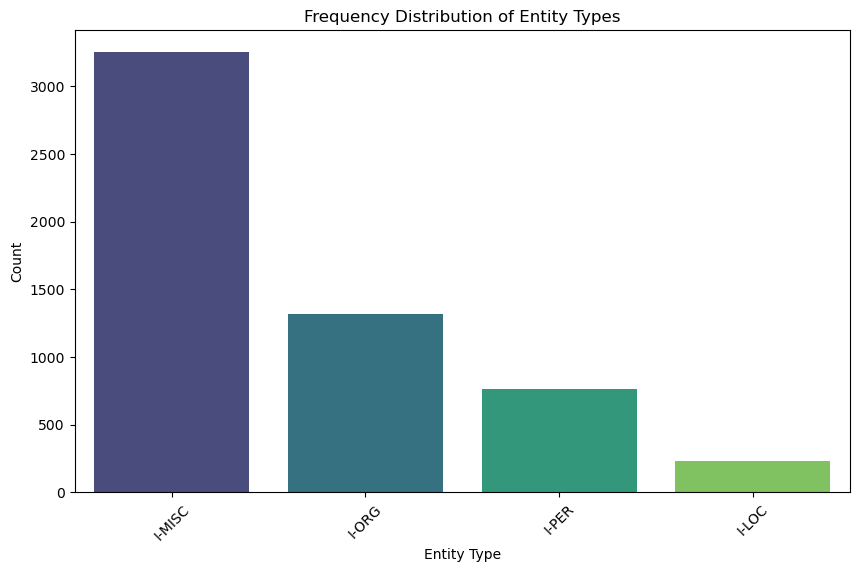

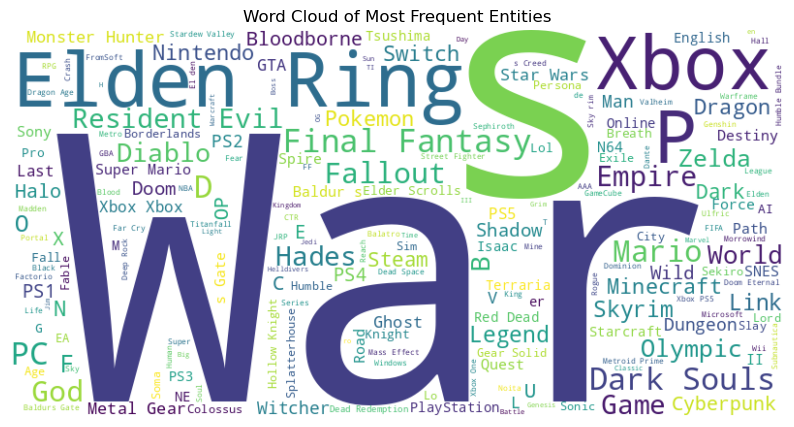

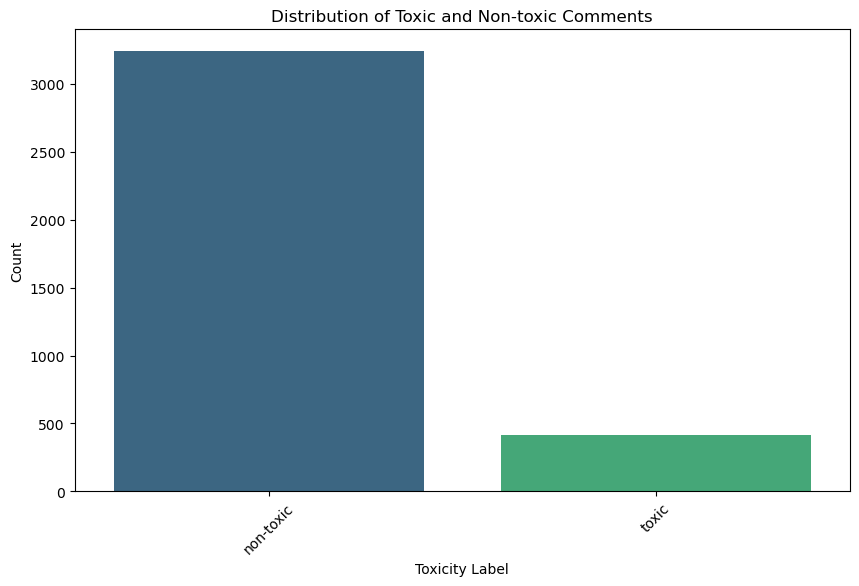

In [6]:
from wordcloud import WordCloud

entity_type_counts = entity_df['type'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=entity_type_counts.index, y=entity_type_counts.values, palette='viridis')
plt.title('Frequency Distribution of Entity Types')
plt.xlabel('Entity Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(entity_list))

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequent Entities')
plt.show()

toxicity_counts = df['toxicity_label'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=toxicity_counts.index, y=toxicity_counts.values, palette='viridis')
plt.title('Distribution of Toxic and Non-toxic Comments')
plt.xlabel('Toxicity Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()
